In [142]:
# TicTacToe

import jax
import flax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
from collections import deque
import random
import optax

##################################################################################################################
########################################## GATO ENVIRONMENT ######################################################
##################################################################################################################

class TicTacToeEnv:
    def __init__(self, current_player=1, board=jnp.zeros(shape=(9,), dtype=int)):
        self.board = board # The state of the gato game
        self.current_player = current_player # The player that is goung to make the next move
        self.reward = 0. # The reward of the actual state of the game
        self.done = False # If the current state is terminal, this is True
        self.o_reward = -2.0 # the reward for O to win
        self.x_reward = 1.0 # the reward for X to win
        self.draw_reward = 1. # the reward for a draw
    
    # Reset the board and starts a new game, where the starting player is X
    def reset(self):
        self.board = jnp.zeros(shape = (9,), dtype = int) # Resets the board to all zeros
        self.current_player = 1 # The default initial player is 1. It can be chaged 
        self.reward = 0. # Initial reward
        self.done = False
    
    # Check if an action proposed is valid
    def is_valid(self, action):
        return self.board[action]==0
    
    # Array containing the valid actions of a given state
    def valid_actions(self):
        valid_actions = jnp.where(self.board == 0)
        return jnp.array(valid_actions).reshape(-1)

    # Checks if a board state is a terminal state. If it is terminal, returns True,
    # and False otherwise. If O (player -1) wins, turns the reward -1, if X (player 1) wins, turns 
    # the reward 1. If it is a draw, reward is 0.5. If it is non-terminal state, reward is 0.
    def is_terminal_state(self):
        state = jnp.reshape(self.board, shape=(3,3))
        state_rot = jnp.rot90(state)

        # if O (-1) wins
        if jnp.any(jnp.sum(state, axis=1)==-3) or jnp.any(jnp.sum(state_rot, axis=1)==-3) or jnp.sum(jnp.diag(state))==-3 or jnp.sum(jnp.diag(state_rot))==-3:
            self.reward = self.o_reward
            self.done = True
            return True

        # if X (1) wins
        elif jnp.any(jnp.sum(state, axis=1)==3) or jnp.any(jnp.sum(state_rot, axis=1)==3) or jnp.sum(jnp.diag(state))==3 or jnp.sum(jnp.diag(state_rot))==3:
            self.reward = self.x_reward
            self.done = True
            return True
        
        # if draw
        elif jnp.all(state != 0):
            self.reward = self.draw_reward
            self.done = True
            return True
        
        else:
            return False
    
    # A step in the game. In takes action, and first check if the board is in a terminal state.
    # If not, then proceed to ask if the action is valid. If it is so, places the value of the current
    # state in the board and changes the current player.
    def step(self, action):

        if self.done:
            return None

        if not self.is_valid(action):
            print(self.valid_actions())
            print("invalid action assholer. Action taken: ", action)
            return None

        self.board = self.board.at[action].set(self.current_player)
        self.current_player *= -1
        self.is_terminal_state()
    
    def print_board(self):
        symbols = {0: "-", 1: "X", -1: "O"}
        board_ = np.vectorize(symbols.get)(self.board.reshape(3,3))
        print("-" * 9)
        for row in board_:
            print(" | ".join(row))
        print("-" * 9)

##################################################################################################################
########################################## DEEP Q FUNCTION  ######################################################
##################################################################################################################

# for now, a feed forward with 2 layers, 32 feat each and relu activation function
class QNetwork(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=32, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(features=32, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(features=9, kernel_init=nn.initializers.xavier_uniform())(x)
        x = jnp.clip(x, -10, 10) #  clip q values to avoid exploding gradients
        return x

##################################################################################################################
########################################## REPLAY BUFFER #########################################################
##################################################################################################################

class ReplayBuffer:
    def __init__(self, capacity):

        # the max length of the replay buffer
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    
    # adds a markov step in the buffer
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    # mathod to sample batch_size samples from buffer
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        # convert arrays to jax arrays
        return (jnp.array(states),
                jnp.array(actions),
                jnp.array(rewards, dtype=jnp.float32),
                jnp.array(next_states),
                jnp.array(dones, dtype=jnp.float32))
    
    # the tamaño of the buffer
    def __len__(self):
        return len(self.buffer)

##################################################################################################################
########################################## LOSS FUNCTION #########################################################
##################################################################################################################

def loss_fn(params, target_params, qnet, batch, gamma):

    # Unpack los batches
    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = batch

    # Compute Q-values from main network 
    # this gives Q(S, A) for all A's
    q_values = qnet.apply(params, batch_states)  # Shape= (batch_size, 9)

    # Compute Q-values from target net
    # this computes Q_target(S', a)
    next_q_values = qnet.apply(target_params, batch_next_states)  # Shape = (batch_size, 9)

    # Compute td error w bellman eq
    # target = reward + gamma max_a Q_target(S', a) (1 - dones)
    # the (1 - dones) is bc the target is just the reward in terminal states
    target = batch_rewards + gamma * jnp.max(next_q_values, axis=1) * (1.0 - batch_dones)

    # clip target to avoid high values
    target = jnp.clip(target, -10, 10)

    # one hot actions
    action_mask = jax.nn.one_hot(batch_actions, num_classes=9)

    # this is Q(S, A)
    predicted = jnp.sum(q_values * action_mask, axis=1)
    
    # loss = Q(S, A) - target
    loss = jnp.mean((predicted - target) ** 2)
    return loss

# jit the loss function for speed
loss_fn_jit = jax.jit(loss_fn, static_argnums=2)

# Create a grad function (also jitted)
grad_loss_fn = jax.jit(jax.grad(loss_fn, argnums=0), static_argnums=2)

##################################################################################################################
###################################### TRAINING FUNCTION #########################################################
##################################################################################################################

# In this training, we assume that the agent is player X (+1). Here, the agent plays against the randomness, and
# the player O (-1) takes random actions. Let me cook
def train_dqn(num_episodes=1000, batch_size=64, buffer_capacity=5000,
              gamma=0.95, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
              learning_rate=0.001, target_tau=0.05, print_every=100, 
              random_key: jax.random.PRNGKey = jax.random.PRNGKey(0),
              optimizer = optax.adam):
    
    # create the environment, the buffer and the network
    env = TicTacToeEnv()
    buffer = ReplayBuffer(buffer_capacity)
    global qnet
    qnet = QNetwork()
    
    # init params
    params = qnet.init(random_key, jnp.array(env.board, dtype=jnp.float32))

    # target params = params at the beggininig
    target_params = params

    # setup optimizer
    optimizer = optimizer(learning_rate)
    opt_state = optimizer.init(params)
    
    # init the epsilon evolution
    epsilon = epsilon_start
    episode_losses = []
    episode_rewards = []
    avg_rewards = []
    avg_losses = []
    
    # initialize for every episode in num_episodes
    for ep in range(num_episodes):

        # initialize episode loss and reward

        ep_loss, ep_reward = 0., 0.

        # restart the environment
        env.reset()

        # Choose the first to play at random
        player_key, random_key = jax.random.split(random_key)
        env.current_player = jax.random.choice(player_key, jnp.array([1, -1]))
        
    # if player O (-1) begins the game (the agent is player 1) take an initial random action
        if env.current_player == -1:

            # Random action for player O (-1)
            action = random.choice(env.valid_actions())
            env.step(action) # this is the state the agent see the first time, so this state is the one to store in bufgfer

        while not env.done:
            # state the agent sees
            agent_state = env.board
            
            # epsilon-greedy action selection from agent policy
            valid = env.valid_actions()  # valid actions indices

            # with probability epsilon takes a random action to enhance exploration
            if random.random() < epsilon:
                action_key, random_key = jax.random.split(random_key)
                agent_action = int(jax.random.choice(action_key, valid))
            else:
                # take an action greedy from q function
                # only consider q values for valid actions
                q_vals = qnet.apply(params, agent_state)
                valid_q = q_vals[valid]
                best_idx = int(jnp.argmax(valid_q))
                agent_action = int(valid[best_idx])

            # agent takes the action
            env.step(agent_action)

            # now, the other agent or the random policy takes an action
            if not env.done:
                # random action for player O (-1)
                random_action = random.choice(env.valid_actions())
                env.step(random_action)
            
            # add experience to replay buffer
            # the states stored are only the ones the agent sees (the one where takes action, and the one after
            # the random policy (player -1) takes an action)
            buffer.add(agent_state, agent_action, env.reward, env.board, env.done)
            
            # sample a minibatchesito when we have enough samples in buffer
            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)

                # compute gradients
                grads = grad_loss_fn(params, target_params, qnet, batch, gamma)

                # clip gradients
                grads = jax.tree.map(lambda g: jnp.clip(g, -5.0, 5.0), grads)

                # update params
                updates, opt_state = optimizer.update(grads, opt_state)
                params = optax.apply_updates(params, updates)

                # soft update target network
                # t * (1 - tau) + p * tau
                target_params = jax.tree.map(lambda t, s: t * (1 - target_tau) + s * target_tau, target_params, params)

        # track losses and rewards of episode
        ep_reward += env.reward
        
        # update epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_end)

        # track rewards and losses
        episode_rewards.append(ep_reward)
        
        # compute loss on a batch to monitor progress
        if len(buffer) >= batch_size:
            batch = buffer.sample(batch_size)
            current_loss = loss_fn_jit(params, target_params, qnet, batch, gamma)
        else:
            current_loss = 0.0
        
        episode_losses.append(current_loss)
        
        # track the thinguis
        if (ep + 1) % print_every == 0:
            avg_reward = np.mean(episode_rewards[-print_every:])
            avg_rewards.append(avg_reward)
            avg_loss = np.mean(episode_losses[-print_every])
            avg_losses.append(avg_loss)
            print(f"Episode {ep+1}, Avg Loss: {current_loss:.4f}, Avg Reward: {avg_reward:.4f}, Epsilon: {epsilon:.4f}")
    
    return params, target_params, episode_losses, episode_rewards, avg_losses, avg_rewards

In [94]:
from matplotlib import pyplot as plt

##################################################################################################################
###################################### TRAINING SOMETHING ########################################################
##################################################################################################################

params, target_params, losses, episode_rewards, avg_losses, avg_rewards = train_dqn(num_episodes=2_000, 
                                                                        print_every=50, 
                                                                        target_tau=0.25,
                                                                        epsilon_end=0.01, 
                                                                        learning_rate=0.0001,
                                                                        batch_size=256)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(avg_losses)
plt.xlabel("Average episodes")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(122)
plt.plot(avg_rewards)
plt.xlabel("Average episodes")
plt.ylabel("Reward")
plt.title("Rewards over episodes")

Episode 50, Avg Loss: 0.0000, Avg Reward: 0.1200, Epsilon: 0.7783
Episode 100, Avg Loss: 0.2700, Avg Reward: 0.0300, Epsilon: 0.6058
Episode 150, Avg Loss: 0.2652, Avg Reward: 0.3600, Epsilon: 0.4715
Episode 200, Avg Loss: 0.3162, Avg Reward: 0.1800, Epsilon: 0.3670
Episode 250, Avg Loss: 0.3065, Avg Reward: 0.4400, Epsilon: 0.2856
Episode 300, Avg Loss: 0.3640, Avg Reward: 0.2700, Epsilon: 0.2223
Episode 350, Avg Loss: 0.4827, Avg Reward: 0.2300, Epsilon: 0.1730


KeyboardInterrupt: 

In [144]:
################################# AGAINST TARGET PARAMS AGENT ####################################################
###################################### TRAINING FUNCTION #########################################################
##################################################################################################################

# In this training, we assume that the agent is player X (+1). Here, the agent plays against the randomness, and
# the player O (-1) takes random actions. Let me cook
def train_dqn_tvt(num_episodes=1000, batch_size=64, target_epsilon=0.3, buffer_capacity=5000,
              gamma=0.95, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
              learning_rate=0.001, target_tau=0.05, print_every=100, 
              random_key: jax.random.PRNGKey = jax.random.PRNGKey(0),
              optimizer = optax.adam):
    
    # create the environment, the buffer and the network
    env = TicTacToeEnv()
    buffer = ReplayBuffer(buffer_capacity)
    global qnet
    qnet = QNetwork()
    
    # init params
    params = qnet.init(random_key, jnp.array(env.board, dtype=jnp.float32))

    # target params = params at the beggininig
    target_params = params

    # setup optimizer
    optimizer = optimizer(learning_rate)
    opt_state = optimizer.init(params)
    
    # init the epsilon evolution
    epsilon = epsilon_start
    episode_losses = []
    episode_rewards = []
    avg_rewards = []
    avg_losses = []
    agent_wins = 0
    other_wins = 0
    draws = 0
    
    # initialize for every episode in num_episodes
    for ep in range(num_episodes):

        # initialize episode loss and reward

        ep_loss, ep_reward = 0., 0.

        # restart the environment
        env.reset()

        # choose the first to play at random
        player_key, random_key = jax.random.split(random_key)
        env.current_player = jax.random.choice(player_key, jnp.array([1, -1]))
        
    # if player O (-1) begins the game (the agent is player 1) take an action from target params agent (epsilon-greedy)
        if env.current_player == -1:
            
            # current state
            state = -env.board

            # epsilon-greedy action selection from agent with target params policy
            valid = env.valid_actions()  # valid actions indices

            # with probability epsilon takes a random action to enhance exploration
            if random.random() < target_epsilon:
                action_key, random_key = jax.random.split(random_key)
                action = int(jax.random.choice(action_key, valid))
            else:
                # take an action greedy from q function
                # only consider q values for valid actions
                q_vals = qnet.apply(target_params, state)
                valid_q = q_vals[valid]
                best_idx = int(jnp.argmax(valid_q))
                action = int(valid[best_idx])

            env.step(action) # this is the state the agent see the first time, so this state is the one to store in bufgfer

        while not env.done:

            # state the agent sees
            agent_state = env.board
            
            # epsilon-greedy action selection from agent policy
            valid = env.valid_actions()  # valid actions indices

            # with probability epsilon takes a random action to enhance exploration
            if random.random() < epsilon:
                action_key, random_key = jax.random.split(random_key)
                agent_action = int(jax.random.choice(action_key, valid))
            else:
                # take an action greedy from q function
                # only consider q values for valid actions
                q_vals = qnet.apply(params, agent_state)
                valid_q = q_vals[valid]
                best_idx = int(jnp.argmax(valid_q))
                agent_action = int(valid[best_idx])

            # agent takes the action
            env.step(agent_action)

            # now, the other agent with target params takes an action
            if not env.done:

                # current state
                state = -env.board

                # epsilon-greedy action selection from agent with target params policy
                valid = env.valid_actions()  # valid actions indices

                # with probability epsilon takes a random action to enhance exploration
                if random.random() < target_epsilon:
                    action_key, random_key = jax.random.split(random_key)
                    action = int(jax.random.choice(action_key, valid))
                else:
                    # take an action greedy from q function
                    # only consider q values for valid actions
                    q_vals = qnet.apply(target_params, state)
                    valid_q = q_vals[valid]
                    best_idx = int(jnp.argmax(valid_q))
                    action = int(valid[best_idx])

                    env.step(action)
            
            # add experience to replay buffer
            # the states stored are only the ones the agent sees (the one where takes action, and the one after
            # the random policy (player -1) takes an action)
            buffer.add(agent_state, agent_action, env.reward, env.board, env.done)
            
            # sample a minibatchesito when we have enough samples in buffer
            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)

                # compute gradients
                grads = grad_loss_fn(params, target_params, qnet, batch, gamma)

                # clip gradients
                grads = jax.tree.map(lambda g: jnp.clip(g, -5.0, 5.0), grads)

                # update params
                updates, opt_state = optimizer.update(grads, opt_state)
                params = optax.apply_updates(params, updates)

                # soft update target network
                # t * (1 - tau) + p * tau
                target_params = jax.tree.map(lambda t, s: t * (1 - target_tau) + s * target_tau, target_params, params)

        # track losses and rewards of episode
        ep_reward += env.reward
        
        # if x (1, the agent) wins
        if env.reward==env.x_reward:
            agent_wins+=1
        
        # if O (-1, the target agent) wins
        elif env.reward==env.o_reward:
            other_wins+=1

        # if draw
        else:
            draws+=1

        # update epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_end)

        # track rewards and losses
        episode_rewards.append(ep_reward)
        
        # compute loss on a batch to monitor progress
        if len(buffer) >= batch_size:
            batch = buffer.sample(batch_size)
            current_loss = loss_fn_jit(params, target_params, qnet, batch, gamma)
        else:
            current_loss = 0.0
        
        episode_losses.append(current_loss)
        
        # track the thinguis
        if (ep + 1) % print_every == 0:
            avg_reward = np.mean(episode_rewards[-print_every:])
            avg_rewards.append(avg_reward)
            avg_loss = np.mean(episode_losses[-print_every])
            avg_losses.append(avg_loss)
            print(f"Episode {ep+1}, Avg Loss: {current_loss:.2f}, Avg Reward: {avg_reward:.2f}, Agent win %: {agent_wins*100./print_every:.2f}, draws %: {draws*100./print_every:.2f}, other win %: {other_wins*100./print_every:.2f}, epsilon: {epsilon:.2f}")
            agent_wins = other_wins = draws = 0
    
    return params, target_params, episode_losses, episode_rewards, avg_losses, avg_rewards

Episode 100, Avg Loss: 3.47, Avg Reward: -0.23, Agent win %: 59.00, draws %: 0.00, other win %: 41.00, epsilon: 0.42
Episode 200, Avg Loss: 1.59, Avg Reward: -0.05, Agent win %: 65.00, draws %: 0.00, other win %: 35.00, epsilon: 0.26
Episode 300, Avg Loss: 4.76, Avg Reward: -0.62, Agent win %: 46.00, draws %: 0.00, other win %: 54.00, epsilon: 0.16
Episode 400, Avg Loss: 2.00, Avg Reward: -0.50, Agent win %: 50.00, draws %: 0.00, other win %: 50.00, epsilon: 0.10
Episode 500, Avg Loss: 5.24, Avg Reward: -0.02, Agent win %: 66.00, draws %: 0.00, other win %: 34.00, epsilon: 0.10
Episode 600, Avg Loss: 3.27, Avg Reward: -0.35, Agent win %: 55.00, draws %: 0.00, other win %: 45.00, epsilon: 0.10
Episode 700, Avg Loss: 4.74, Avg Reward: -0.14, Agent win %: 62.00, draws %: 0.00, other win %: 38.00, epsilon: 0.10
Episode 800, Avg Loss: 3.96, Avg Reward: -0.35, Agent win %: 55.00, draws %: 0.00, other win %: 45.00, epsilon: 0.10
Episode 900, Avg Loss: 2.82, Avg Reward: -0.20, Agent win %: 60.

Text(0.5, 1.0, 'Rewards over episodes')

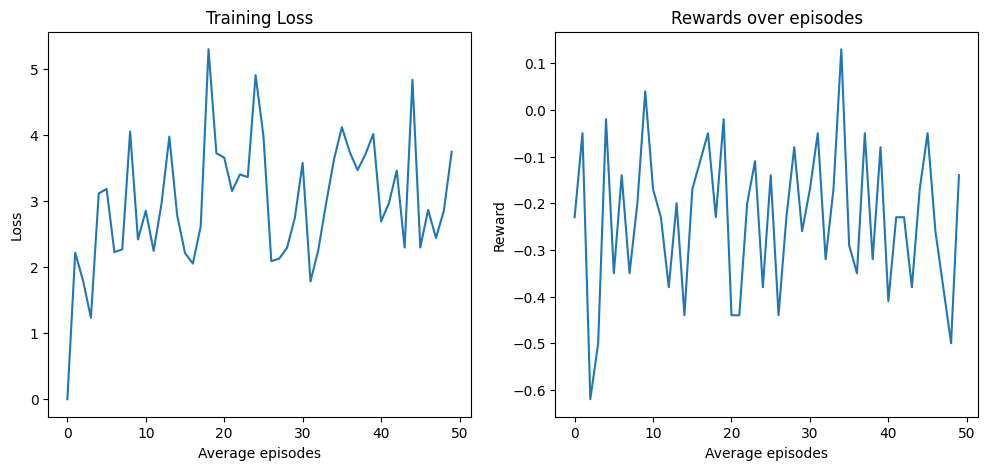

In [145]:
from matplotlib import pyplot as plt

##################################################################################################################
###################################### TRAINING SOMETHING ########################################################
##################################################################################################################

params, target_params, losses, episode_rewards, avg_losses, avg_rewards = train_dqn_tvt(num_episodes=5_000, 
                                                                        print_every=100, 
                                                                        target_tau=0.05,
                                                                        epsilon_start=0.7,
                                                                        epsilon_end=0.1,
                                                                        epsilon_decay=0.995,
                                                                        learning_rate=0.01,
                                                                        gamma=0.9,
                                                                        target_epsilon=0.5,
                                                                        batch_size=128)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(avg_losses)
plt.xlabel("Average episodes")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(122)
plt.plot(avg_rewards)
plt.xlabel("Average episodes")
plt.ylabel("Reward")
plt.title("Rewards over episodes")

In [131]:
def play_against_agent(env, qnet, params, random_key=jax.random.PRNGKey(0)):
    def get_agent_action(state):
        q_values = qnet.apply(params, state)
        valid_actions = jnp.arange(9)[env.valid_actions()]
        return valid_actions[jnp.argmax(q_values[valid_actions])]

    def get_human_action():
        while True:
            try:
                action = int(input("Enter your move (0-8): "))
                if action in env.valid_actions():
                    return action
                else:
                    print("Invalid move. Try again.")
            except ValueError:
                print("Invalid input. Enter a number between 0 and 8.")

    env.reset()
    env.print_board()

    env.current_player = int(input("Do you want to play first (-1) or second (1)? "))

    while not env.done:
        if env.current_player == -1:
            action = get_human_action()
        else:
            action = get_agent_action(env.board)
            print(f"Agent's move: {action}")

        env.step(action)
        env.print_board()

    if env.reward == env.x_reward:
        print("Agent wins!")
    elif env.reward == env.o_reward:
        print("You win!")
    else:
        print("It's a draw!")

# Play against the trained agent
env = TicTacToeEnv()
play_against_agent(env, qnet, params)

---------
- | - | -
- | - | -
- | - | -
---------
Agent's move: 1
---------
- | X | -
- | - | -
- | - | -
---------
---------
- | X | -
- | O | -
- | - | -
---------
Agent's move: 7
---------
- | X | -
- | O | -
- | X | -
---------
---------
- | X | -
O | O | -
- | X | -
---------
Agent's move: 0
---------
X | X | -
O | O | -
- | X | -
---------
---------
X | X | -
O | O | O
- | X | -
---------
You win!


In [35]:
# ChatGPT thingui

import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
import optax
import random
from collections import deque

# =============================================================================
# 1. Environment Definition: Tic Tac Toe
# =============================================================================
class TicTacToeEnv:
    def __init__(self):
        # We'll represent the board as a 1D array of 9 elements.
        # 0 = empty, 1 = X, -1 = O.
        self.board = np.zeros(9, dtype=np.int32)
        self.current_player = 1  # Player 1 (X) starts.
        self.reward = 0.0
        self.done = False

    def reset(self):
        self.board = np.zeros(9, dtype=np.int32)
        self.current_player = 1
        self.reward = 0.0
        self.done = False
        return self.board.copy()  # Return a copy so callers don’t accidentally modify it.

    def valid_actions(self):
        # Returns indices (0 to 8) where board is empty.
        return np.where(self.board == 0)[0]

    def is_valid(self, action):
        return self.board[action] == 0

    def is_terminal_state(self):
        # Reshape board into 3x3 for checking win/draw.
        state = self.board.reshape(3, 3)
        # Check rows, columns, and diagonals.
        for i in range(3):
            if abs(np.sum(state[i, :])) == 3:
                return True, np.sign(np.sum(state[i, :]))
            if abs(np.sum(state[:, i])) == 3:
                return True, np.sign(np.sum(state[:, i]))
        diag1 = np.sum(np.diag(state))
        diag2 = np.sum(np.diag(np.fliplr(state)))
        if abs(diag1) == 3:
            return True, np.sign(diag1)
        if abs(diag2) == 3:
            return True, np.sign(diag2)
        # If board is full, it's a draw.
        if np.all(state != 0):
            return True, 0
        return False, None

    def step(self, action):
        # Check if game is already over.
        if self.done:
            return self.board.copy(), self.reward, self.done

        # If the action is invalid, we penalize slightly and end the game.
        if not self.is_valid(action):
            self.reward = -0.5
            self.done = True
            return self.board.copy(), self.reward, self.done

        # Apply the action.
        self.board[action] = self.current_player

        # Check if game is over.
        terminal, winner = self.is_terminal_state()
        if terminal:
            self.done = True
            if winner == 1:
                self.reward = 1.0  # Win reward.
            elif winner == -1:
                self.reward = -1.0  # Loss penalty.
            else:
                self.reward = 0.5  # Draw reward.
        else:
            self.reward = 0.0

        # Switch player.
        self.current_player *= -1
        return self.board.copy(), self.reward, self.done

    def print_board(self):
        symbols = {0: '-', 1: 'X', -1: 'O'}
        board_2d = self.board.reshape(3, 3)
        for row in board_2d:
            print(" | ".join(symbols[x] for x in row))
        print()

# =============================================================================
# 2. Q-Network Definition (using Flax)
# =============================================================================
class QNetwork(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Input x should be a flat vector of size 9.
        x = nn.Dense(32, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(32, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(9, kernel_init=nn.initializers.xavier_uniform())(x)
        # Optionally clip output to keep Q-values bounded.
        x = jnp.clip(x, -10, 10)
        return x

# =============================================================================
# 3. Replay Buffer
# =============================================================================
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        # Convert arrays to jax.numpy arrays.
        return (jnp.array(states),
                jnp.array(actions),
                jnp.array(rewards, dtype=jnp.float32),
                jnp.array(next_states),
                jnp.array(dones, dtype=jnp.float32))
    
    def __len__(self):
        return len(self.buffer)

# =============================================================================
# 4. Loss Function (Using standard DQN loss)
# =============================================================================
def loss_fn(params, target_params, batch_states, batch_actions, batch_rewards, 
            batch_next_states, batch_dones, gamma):
    # Compute Q-values from main network.
    q_values = qnet.apply(params, batch_states)  # Shape: (batch_size, 9)
    # Compute Q-values from target network.
    next_q_values = qnet.apply(target_params, batch_next_states)  # Shape: (batch_size, 9)
    # Compute target using Bellman equation.
    target = batch_rewards + gamma * jnp.max(next_q_values, axis=1) * (1.0 - batch_dones)
    # Clip target to avoid extreme values.
    target = jnp.clip(target, -10, 10)
    # One-hot encode actions.
    action_mask = jax.nn.one_hot(batch_actions, num_classes=9)
    predicted = jnp.sum(q_values * action_mask, axis=1)
    # Mean squared error loss.
    loss = jnp.mean((predicted - target) ** 2)
    return loss

# jit the loss function for speed.
loss_fn_jit = jax.jit(loss_fn)
# Create a grad function.
grad_loss_fn = jax.jit(jax.grad(loss_fn, argnums=0))

# =============================================================================
# 5. Training Function
# =============================================================================
def train_dqn(num_episodes=1000, batch_size=64, buffer_capacity=5000,
              gamma=0.95, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
              learning_rate=0.001, target_tau=0.05, print_every=100):
    
    # Create environment, network, and replay buffer.
    env = TicTacToeEnv()
    buffer = ReplayBuffer(buffer_capacity)
    global qnet
    qnet = QNetwork()
    
    # Initialize network parameters.
    key = jax.random.PRNGKey(0)
    params = qnet.init(key, jnp.array(env.reset(), dtype=jnp.float32))
    target_params = params
    # Setup optimizer.
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    epsilon = epsilon_start
    episode_losses = []
    episode_rewards = []
    
    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        # Player -1 begins the game (the agent is player 1)
        if env.current_player == -1:
            # Random action for player O.
            action = random.choice(env.valid_actions())
            state, _, _ = env.step(action) # This is the state the agent see the first time

        while not done:
            # Convert state to float32 and flatten.
            state_in = jnp.array(state, dtype=jnp.float32)
            
            # Epsilon-greedy action selection.
            q_vals = qnet.apply(params, state_in)
            valid = env.valid_actions()  # valid actions indices.
            if random.random() < epsilon:
                action = int(random.choice(valid.tolist()))
            else:
                # Only consider Q-values for valid actions.
                valid_q = q_vals[valid]
                best_idx = int(jnp.argmax(valid_q))
                action = int(valid[best_idx])

            # Take step in environment.
            next_state, reward, done = env.step(action)
            total_reward += reward

            if not env.done:
                # Random action for player O.
                action = random.choice(env.valid_actions())
                next_state, _, _ = env.step(action)
            
            # Add experience to replay buffer.
            buffer.add(state, action, reward, next_state, done)
            state = next_state  # move to next state.
            
            # When enough samples are available, sample a minibatch.
            if len(buffer) >= batch_size:
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = buffer.sample(batch_size)
                # Compute gradients.
                grads = grad_loss_fn(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones, gamma)
                # Optionally, clip gradients.
                grads = jax.tree_util.tree_map(lambda g: jnp.clip(g, -5.0, 5.0), grads)
                updates, opt_state = optimizer.update(grads, opt_state)
                params = optax.apply_updates(params, updates)
                # Soft update target network.
                target_params = jax.tree_util.tree_map(lambda t, s: t * (1 - target_tau) + s * target_tau, target_params, params)
        
        # Anneal epsilon.
        epsilon = max(epsilon * epsilon_decay, epsilon_end)
        episode_rewards.append(total_reward)
        
        # Optionally compute loss on a batch to monitor progress.
        if len(buffer) >= batch_size:
            batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = buffer.sample(batch_size)
            current_loss = loss_fn_jit(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones, gamma)
        else:
            current_loss = 0.0
        
        episode_losses.append(current_loss)
        
        if (ep + 1) % print_every == 0:
            avg_reward = np.mean(episode_rewards[-print_every:])
            print(f"Episode {ep+1}, Loss: {current_loss:.4f}, Avg Reward: {avg_reward:.4f}, Epsilon: {epsilon:.4f}")
    
    return params, target_params, episode_losses, episode_rewards

# =============================================================================
# 6. Run Training
# =============================================================================
params, target_params, losses, rewards = train_dqn(num_episodes=10_000)



Episode 100, Loss: 7.1143, Avg Reward: 0.3600, Epsilon: 0.6058


KeyboardInterrupt: 

In [9]:
env.step(5)

[ 1 -1  1  0  0 -1  0  0  0]
[ 1 -1  1  0  0 -1  0  0  0]


In [5]:
# 2. Define the model
# A simple neural network with 2 hidden layers of 64 units each, and a final layer with 9 units,
# each of which represent the Q-values of each action in the game.
class QNetwork(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=32, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(features=32, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(features=9, kernel_init=nn.initializers.xavier_uniform())(x)
        x = jnp.clip(x, -10, 10) # Clip the Q-values to avoid exploding gradients
        return x

In [ ]:
import optax
import random
from collections import deque
from functools import partial

def loss_fn(params, target_params, batch_states, batch_actions, batch_rewards, 
            batch_next_states, batch_dones, gamma):


loss_fn_jit = jax.jit(loss_fn)
loss_grad = jax.jit(jax.grad(loss_fn, argnums=0))

# Without buffer
def dql_algorithm(env, qnet, optimizer=None, params=None, num_episodes=1_000, ep_print = 100, mean_reward_update=100,
                  epsilon=0., gamma=0.99, learning_rate=0.01, buffer_len=64,
                  target_update_freq=10, random_key: jax.random.PRNGKey = jax.random.PRNGKey(0)):
    
    if optimizer==None:
        optimizer=optax.adam(learning_rate)

    if params==None:
        params_key, random_key = jax.random.split(random_key)
        params=qnet.init(params_key, env.net_state())
    tau = 0.01  # Small update step
    opt_state = optimizer.init(params)
    target_params = params
    rewards = deque(maxlen=mean_reward_update)
    mean_rewards = []
    episode_losses = []

    def epsilon_greedy(q_values):
        epsi_key, int_key = jax.random.split(random_key)
        if jax.random.uniform(epsi_key) < epsilon:
            return jax.random.choice(int_key, env.valid_actions())
        else:
            #actions = jnp.arange(9)[env.valid_actions()]
            #return actions[jnp.argmax(q_values[env.valid_actions()])]
            valid_actions = env.valid_actions()
            return valid_actions[jnp.argmax(q_values[valid_actions])]

    ep_buffer = deque(maxlen=buffer_len)
    for ep in range(num_episodes):
        epsilon = max(epsilon, 1.0 - (ep / num_episodes))
        #print(f"Episode {ep+1}")
        env.reset()
        curr_key, random_key = jax.random.split(random_key)
        env.current_player = jax.random.choice(curr_key, jnp.array([-1, 1]))
        episode_loss = 0

        # If first player is not the agent, take a random action first
        if env.current_player==-1:

            # random action
            act_key, random_key = jax.random.split(random_key)
            random_action = jax.random.choice(act_key, env.valid_actions())
            env.step(random_action)

        while not env.done:

            # Agent plays first
            agent_state = env.board
            q_values = qnet.apply(params, agent_state)
            agent_action = epsilon_greedy(q_values)
            env.step(agent_action)

            if not env.done:
                # random action
                act_key, random_key = jax.random.split(random_key)
                random_action = jax.random.choice(act_key, env.valid_actions())
                env.step(random_action)

            # Store experience in replay buffer 
            ep_buffer.append((agent_state, agent_action, env.reward, env.board, env.done))


        ep_states, ep_actions, ep_rewards, ep_next_states, ep_dones = zip(*ep_buffer)
                
        ep_states = jnp.array(ep_states)
        ep_actions = jnp.array(ep_actions)
        ep_rewards = jnp.array(ep_rewards)
        ep_next_states = jnp.array(ep_next_states)
        ep_dones = jnp.array(ep_dones)

        # Compute loss
        grads = loss_grad(params, target_params, ep_states, ep_actions, 
                                                ep_rewards, ep_next_states, ep_dones, gamma)
        
        grads = jax.tree.map(lambda g: jnp.clip(g, -5.0, 5.0), grads)

        episode_loss += loss_fn_jit(params, target_params, ep_states, ep_actions, 
                                        ep_rewards, ep_next_states, ep_dones, gamma)
                
        # Update the Q-network
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        #params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)

        episode_losses.append(episode_loss)
        
        rewards.append(env.reward)
        

        # Update the target network every few episodes
        #if ep % target_update_freq == 0:
            #target_params = params
        
        target_params = jax.tree_util.tree_map(
            lambda t, s: t * (1 - tau) + s * tau, target_params, params
            )
        
        if ep % mean_reward_update == 0:
            mean_rewards.append(jnp.mean(jnp.array(rewards)))

        #if (ep+1) % ep_print == 0:
        #    print(f"Episode {ep+1}, Loss: {episode_loss}, mean reward: {mean_rewards[-1]}")

        #if (ep + 1) % ep_print == 0:
        #    print(f"Episode {ep+1}, Loss: {episode_loss}, Mean Reward: {mean_rewards[-1]}")
        #    q_values_before = qnet.apply(params, env.net_state())
        #    print(f"Q-values before update: {q_values_before}")

        if (ep + 1) % ep_print == 0:
            print(f"Episode {ep+1}, Loss: {episode_loss}, Mean Reward: {mean_rewards[-1]}")
            q_before = qnet.apply(params, env.net_state())
            print(f"Q-values before update: {q_before}")

            grads = loss_grad(params, target_params, ep_states, ep_actions, ep_rewards, ep_next_states, ep_dones, gamma)

            grads = jax.tree.map(lambda g: jnp.clip(g, -1.0, 1.0), grads)  # Clip grads
            grads, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, grads)

            q_after = qnet.apply(params, env.net_state())
            print(f"Q-values after update: {q_after}")

    return params, episode_losses, mean_rewards

In [9]:
env = TicTacToeEnv()
qnet = QNetwork()
params = qnet.init(jax.random.PRNGKey(0), env.board)
params, episode_losses, rewards = dql_algorithm(env, qnet, target_update_freq=1, num_episodes=1_000,
                                                gamma=0.95, learning_rate=0.01)

Episode 100, Loss: 0.15947960317134857, Mean Reward: -1.0
Q-values before update: [-0.04073201  0.5341692  -0.36352202  0.7167789  -0.1176977   0.36190072
  0.77225703  0.21399355 -0.254688  ]
Q-values after update: [-0.05629346  0.49457616 -0.36997706  0.5791352  -0.10588051  0.36842644
  0.69937575  0.16331539 -0.25892663]
Episode 200, Loss: 0.13037708401679993, Mean Reward: 0.14000000059604645
Q-values before update: [ 1.1849912  -0.17876501  0.06117823  1.1263512   1.410596    0.5900279
  1.4529951   0.2696799   0.47751904]
Q-values after update: [ 1.2082074  -0.20992917  0.05241633  1.1430007   1.4064195   0.6426413
  1.427655    0.27782565  0.5005185 ]
Episode 300, Loss: 0.21326306462287903, Mean Reward: 0.26499998569488525
Q-values before update: [ 0.5603848   0.12758297  0.0936624  -0.1068617   0.26474395  0.309486
  0.08717625 -0.00280733  0.44177675]
Q-values after update: [ 0.53468007  0.09574544  0.09622069 -0.12301761  0.22014752  0.26475495
  0.04369963  0.02438369  0.412

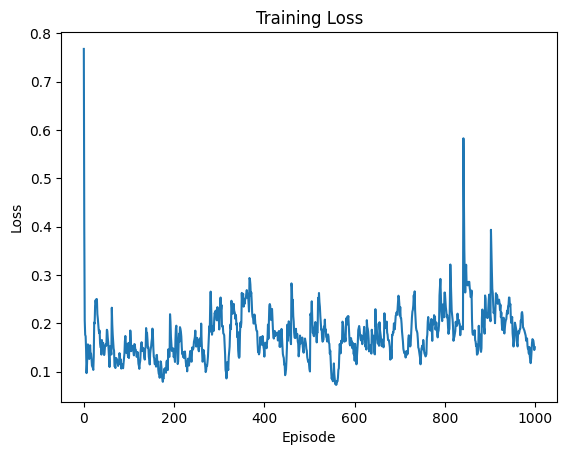

In [10]:
import matplotlib.pyplot as plt

plt.plot(episode_losses)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

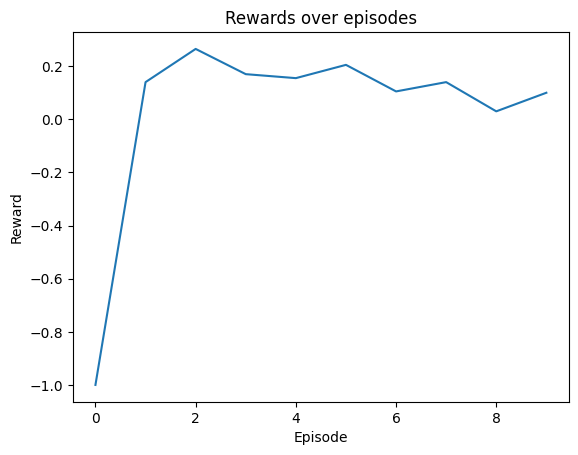

In [11]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Rewards over episodes")
plt.show()

Episode 500, Loss: 0.3074113130569458, mean reward: 0.04999999701976776
Episode 1000, Loss: 1.335113286972046, mean reward: 0.19499999284744263
Episode 500, Loss: 21387.759765625, mean reward: -0.25999999046325684
Episode 1000, Loss: 3644752.5, mean reward: -0.3349999785423279
Episode 500, Loss: 0.32309430837631226, mean reward: -0.1550000011920929
Episode 1000, Loss: 0.3482149839401245, mean reward: 0.07499999552965164
Episode 500, Loss: 0.3325539529323578, mean reward: 0.12999999523162842
Episode 1000, Loss: 0.3110201954841614, mean reward: 0.23999999463558197


<Figure size 1200x500 with 0 Axes>

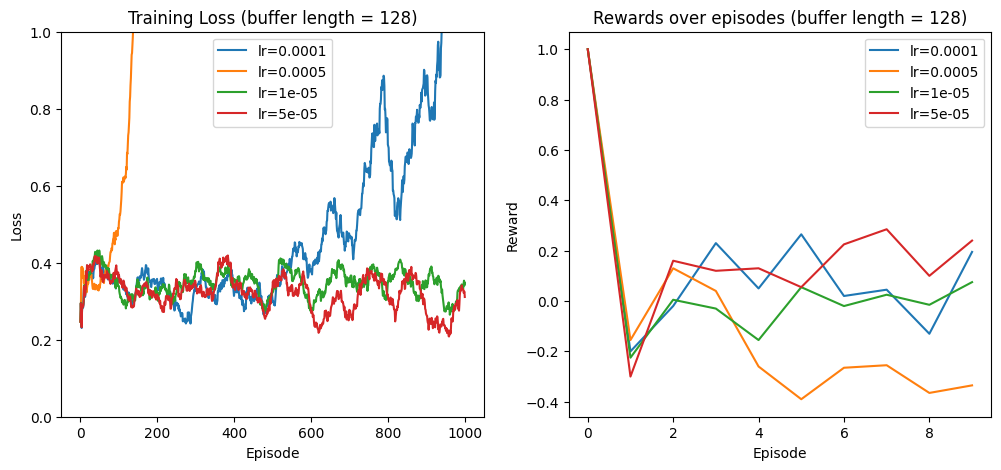

Episode 500, Loss: 0.39900869131088257, mean reward: 0.1599999964237213
Episode 1000, Loss: 6.3546648025512695, mean reward: 0.06499999761581421
Episode 500, Loss: 26052.7890625, mean reward: -0.4449999928474426
Episode 1000, Loss: 3579228.25, mean reward: -0.5
Episode 500, Loss: 0.3424111008644104, mean reward: -0.05999999865889549
Episode 1000, Loss: 0.35639917850494385, mean reward: -0.019999999552965164
Episode 500, Loss: 0.3354860842227936, mean reward: -0.08500000089406967
Episode 1000, Loss: 0.33834323287010193, mean reward: 0.29499998688697815


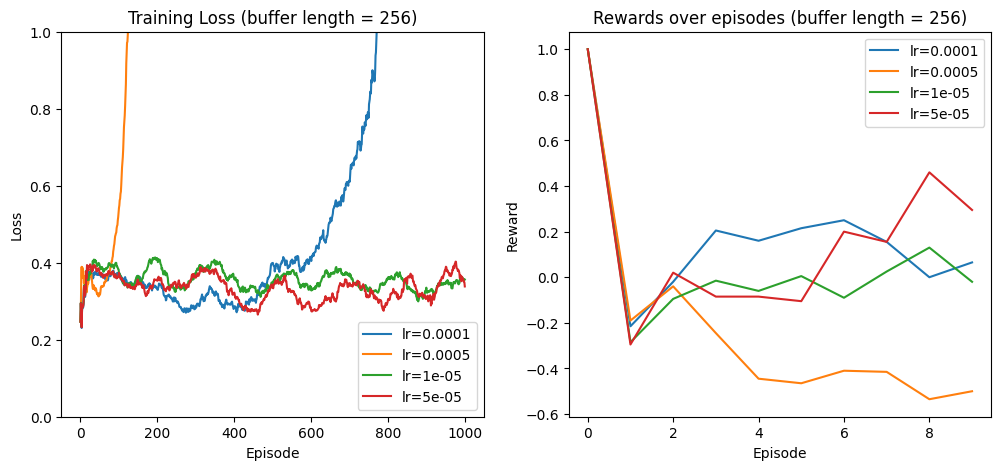

Episode 500, Loss: 0.35639435052871704, mean reward: 0.19499999284744263
Episode 1000, Loss: 13.214996337890625, mean reward: 0.14000000059604645
Episode 500, Loss: 19906.5703125, mean reward: -0.4599999785423279
Episode 1000, Loss: 3225060.0, mean reward: -0.375
Episode 500, Loss: 0.3291061222553253, mean reward: -0.07499999552965164
Episode 1000, Loss: 0.35409435629844666, mean reward: -0.07999999821186066
Episode 500, Loss: 0.3029699921607971, mean reward: -0.019999999552965164
Episode 1000, Loss: 0.3298073410987854, mean reward: 0.2800000011920929


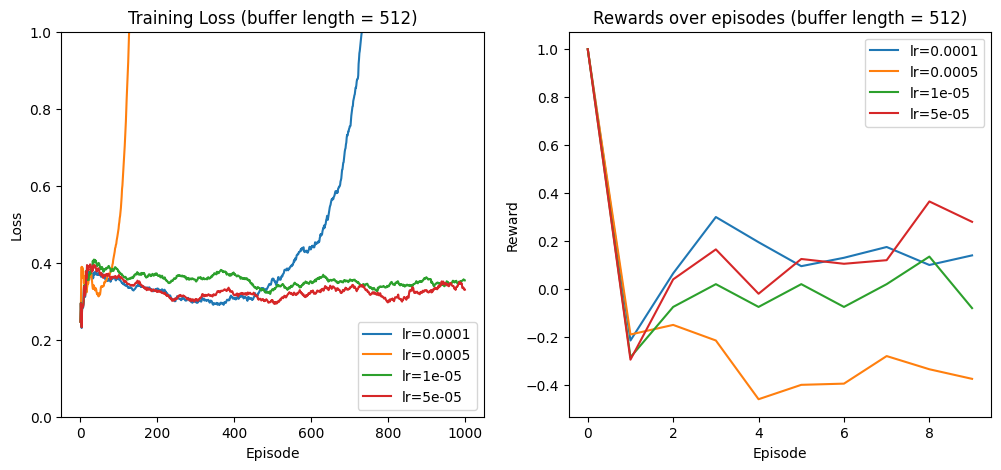

Episode 500, Loss: 0.3235376477241516, mean reward: 0.10999999940395355
Episode 1000, Loss: 0.871484100818634, mean reward: 0.1899999976158142
Episode 500, Loss: 30727.8515625, mean reward: -0.26999998092651367
Episode 1000, Loss: 872143.875, mean reward: -0.4350000023841858
Episode 500, Loss: 0.34530162811279297, mean reward: -0.044999998062849045
Episode 1000, Loss: 0.34175270795822144, mean reward: -0.09999999403953552
Episode 500, Loss: 0.30527830123901367, mean reward: 0.07999999821186066
Episode 1000, Loss: 0.3510572016239166, mean reward: 0.4050000011920929


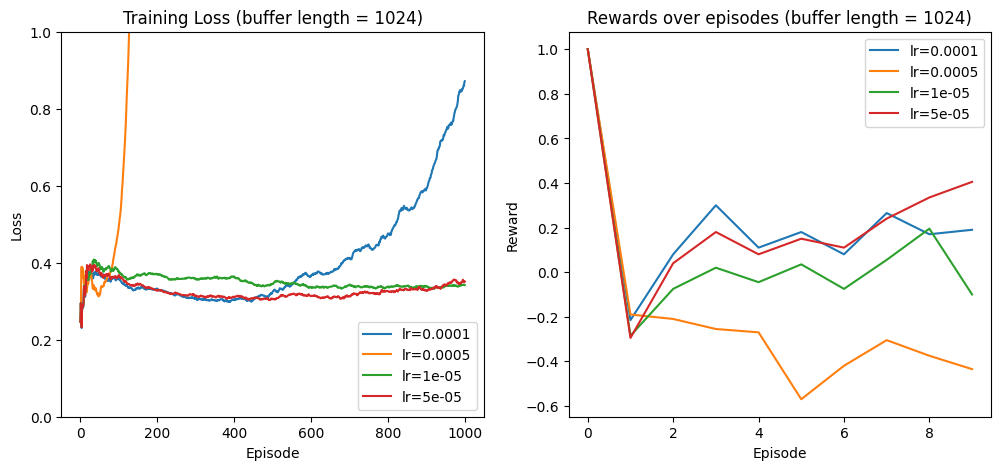

In [199]:
lrs = [1e-4, 5e-4, 1e-5, 5e-5]
buffer_lens = [128, 256, 512, 1024]

plt.figure(figsize=(12, 5))

for buflen in buffer_lens:
    plt.figure(figsize=(12, 5))
    for learning_rate in lrs:
        env = TicTacToeEnv()
        qnet = QNetwork()
        params = qnet.init(jax.random.PRNGKey(0), env.board)
        params, episode_losses, rewards = dql_algorithm(env, qnet, target_update_freq=1, num_episodes=1_000, buffer_len=buflen,
                                                        gamma=0.9, learning_rate=learning_rate, ep_print=500)
        
        plt.subplot(121)
        plt.plot(episode_losses, label=f"lr={learning_rate}")
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.title("Training Loss (buffer length = {})".format(buflen))
        plt.ylim(0, 1.)
        plt.legend()
        
        plt.subplot(122)
        plt.plot(rewards, label=f"lr={learning_rate}")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("Rewards over episodes (buffer length = {})".format(buflen))
        plt.legend()

    plt.show()


In [ ]:
# ChatGPT thingui

import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
import optax
import random
from collections import deque

# =============================================================================
# 1. Environment Definition: Tic Tac Toe
# =============================================================================
class TicTacToeEnv:
    def __init__(self):
        # We'll represent the board as a 1D array of 9 elements.
        # 0 = empty, 1 = X, -1 = O.
        self.board = np.zeros(9, dtype=np.int32)
        self.current_player = 1  # Player 1 (X) starts.
        self.reward = 0.0
        self.done = False

    def reset(self):
        self.board = np.zeros(9, dtype=np.int32)
        self.current_player = 1
        self.reward = 0.0
        self.done = False
        return self.board.copy()  # Return a copy so callers don’t accidentally modify it.

    def valid_actions(self):
        # Returns indices (0 to 8) where board is empty.
        return np.where(self.board == 0)[0]

    def is_valid(self, action):
        return self.board[action] == 0

    def is_terminal_state(self):
        # Reshape board into 3x3 for checking win/draw.
        state = self.board.reshape(3, 3)
        # Check rows, columns, and diagonals.
        for i in range(3):
            if abs(np.sum(state[i, :])) == 3:
                return True, np.sign(np.sum(state[i, :]))
            if abs(np.sum(state[:, i])) == 3:
                return True, np.sign(np.sum(state[:, i]))
        diag1 = np.sum(np.diag(state))
        diag2 = np.sum(np.diag(np.fliplr(state)))
        if abs(diag1) == 3:
            return True, np.sign(diag1)
        if abs(diag2) == 3:
            return True, np.sign(diag2)
        # If board is full, it's a draw.
        if np.all(state != 0):
            return True, 0
        return False, None

    def step(self, action):
        # Check if game is already over.
        if self.done:
            return self.board.copy(), self.reward, self.done

        # If the action is invalid, we penalize slightly and end the game.
        if not self.is_valid(action):
            self.reward = -0.5
            self.done = True
            return self.board.copy(), self.reward, self.done

        # Apply the action.
        self.board[action] = self.current_player

        # Check if game is over.
        terminal, winner = self.is_terminal_state()
        if terminal:
            self.done = True
            if winner == 1:
                self.reward = 1.0  # Win reward.
            elif winner == -1:
                self.reward = -1.0  # Loss penalty.
            else:
                self.reward = 0.5  # Draw reward.
        else:
            self.reward = 0.0

        # Switch player.
        self.current_player *= -1
        return self.board.copy(), self.reward, self.done

    def print_board(self):
        symbols = {0: '-', 1: 'X', -1: 'O'}
        board_2d = self.board.reshape(3, 3)
        for row in board_2d:
            print(" | ".join(symbols[x] for x in row))
        print()

# =============================================================================
# 2. Q-Network Definition (using Flax)
# =============================================================================
class QNetwork(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Input x should be a flat vector of size 9.
        x = nn.Dense(32, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(32, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(9, kernel_init=nn.initializers.xavier_uniform())(x)
        # Optionally clip output to keep Q-values bounded.
        x = jnp.clip(x, -10, 10)
        return x

# =============================================================================
# 3. Replay Buffer
# =============================================================================
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        # Convert arrays to jax.numpy arrays.
        return (jnp.array(states),
                jnp.array(actions),
                jnp.array(rewards, dtype=jnp.float32),
                jnp.array(next_states),
                jnp.array(dones, dtype=jnp.float32))
    
    def __len__(self):
        return len(self.buffer)

# =============================================================================
# 4. Loss Function (Using standard DQN loss)
# =============================================================================
def loss_fn(params, target_params, batch_states, batch_actions, batch_rewards, 
            batch_next_states, batch_dones, gamma):
    # Compute Q-values from main network.
    q_values = qnet.apply(params, batch_states)  # Shape: (batch_size, 9)
    # Compute Q-values from target network.
    next_q_values = qnet.apply(target_params, batch_next_states)  # Shape: (batch_size, 9)
    # Compute target using Bellman equation.
    target = batch_rewards + gamma * jnp.max(next_q_values, axis=1) * (1.0 - batch_dones)
    # Clip target to avoid extreme values.
    target = jnp.clip(target, -10, 10)
    # One-hot encode actions.
    action_mask = jax.nn.one_hot(batch_actions, num_classes=9)
    predicted = jnp.sum(q_values * action_mask, axis=1)
    # Mean squared error loss.
    loss = jnp.mean((predicted - target) ** 2)
    return loss

# jit the loss function for speed.
loss_fn_jit = jax.jit(loss_fn)
# Create a grad function.
grad_loss_fn = jax.jit(jax.grad(loss_fn, argnums=0))

# =============================================================================
# 5. Training Function
# =============================================================================
def train_dqn(num_episodes=1000, batch_size=64, buffer_capacity=5000,
              gamma=0.95, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
              learning_rate=0.001, target_tau=0.05, print_every=100):
    
    # Create environment, network, and replay buffer.
    env = TicTacToeEnv()
    buffer = ReplayBuffer(buffer_capacity)
    global qnet
    qnet = QNetwork()
    
    # Initialize network parameters.
    key = jax.random.PRNGKey(0)
    params = qnet.init(key, jnp.array(env.reset(), dtype=jnp.float32))
    target_params = params
    # Setup optimizer.
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    epsilon = epsilon_start
    episode_losses = []
    episode_rewards = []
    
    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        # Player -1 begins the game (the agent is player 1)
        if env.current_player == -1:
            # Random action for player O.
            action = random.choice(env.valid_actions())
            state, _, _ = env.step(action) # This is the state the agent see the first time

        while not done:
            # Convert state to float32 and flatten.
            state_in = jnp.array(state, dtype=jnp.float32)
            
            # Epsilon-greedy action selection.
            q_vals = qnet.apply(params, state_in)
            valid = env.valid_actions()  # valid actions indices.
            if random.random() < epsilon:
                action = int(random.choice(valid.tolist()))
            else:
                # Only consider Q-values for valid actions.
                valid_q = q_vals[valid]
                best_idx = int(jnp.argmax(valid_q))
                action = int(valid[best_idx])

            # Take step in environment.
            next_state, reward, done = env.step(action)
            total_reward += reward

            if not env.done:
                # Random action for player O.
                action = random.choice(env.valid_actions())
                next_state, _, _ = env.step(action)
            
            # Add experience to replay buffer.
            buffer.add(state, action, reward, next_state, done)
            state = next_state  # move to next state.
            
            # When enough samples are available, sample a minibatch.
            if len(buffer) >= batch_size:
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = buffer.sample(batch_size)
                # Compute gradients.
                grads = grad_loss_fn(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones, gamma)
                # Optionally, clip gradients.
                grads = jax.tree_util.tree_map(lambda g: jnp.clip(g, -5.0, 5.0), grads)
                updates, opt_state = optimizer.update(grads, opt_state)
                params = optax.apply_updates(params, updates)
                # Soft update target network.
                target_params = jax.tree_util.tree_map(lambda t, s: t * (1 - target_tau) + s * target_tau, target_params, params)
        
        # Anneal epsilon.
        epsilon = max(epsilon * epsilon_decay, epsilon_end)
        episode_rewards.append(total_reward)
        
        # Optionally compute loss on a batch to monitor progress.
        if len(buffer) >= batch_size:
            batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = buffer.sample(batch_size)
            current_loss = loss_fn_jit(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones, gamma)
        else:
            current_loss = 0.0
        
        episode_losses.append(current_loss)
        
        if (ep + 1) % print_every == 0:
            avg_reward = np.mean(episode_rewards[-print_every:])
            print(f"Episode {ep+1}, Loss: {current_loss:.4f}, Avg Reward: {avg_reward:.4f}, Epsilon: {epsilon:.4f}")
    
    return params, target_params, episode_losses, episode_rewards

# =============================================================================
# 6. Run Training
# =============================================================================
params, target_params, losses, rewards = train_dqn(num_episodes=10_000)



Episode 100, Loss: 5.3014, Avg Reward: 0.3950, Epsilon: 0.6058
Episode 200, Loss: 4.4979, Avg Reward: 0.3150, Epsilon: 0.3670
Episode 300, Loss: 2.6436, Avg Reward: 0.2400, Epsilon: 0.2223
Episode 400, Loss: 1.3462, Avg Reward: 0.1050, Epsilon: 0.1347
Episode 500, Loss: 1.7621, Avg Reward: 0.3900, Epsilon: 0.0816
Episode 600, Loss: 2.9635, Avg Reward: 0.3650, Epsilon: 0.0494
Episode 700, Loss: 2.5499, Avg Reward: 0.3150, Epsilon: 0.0299
Episode 800, Loss: 1.1148, Avg Reward: 0.4500, Epsilon: 0.0181
Episode 900, Loss: 1.6446, Avg Reward: 0.3900, Epsilon: 0.0110
Episode 1000, Loss: 1.1563, Avg Reward: 0.4550, Epsilon: 0.0100
Episode 1100, Loss: 0.9515, Avg Reward: 0.3850, Epsilon: 0.0100
Episode 1200, Loss: 1.1739, Avg Reward: 0.3000, Epsilon: 0.0100
Episode 1300, Loss: 1.4112, Avg Reward: 0.3800, Epsilon: 0.0100
Episode 1400, Loss: 0.7430, Avg Reward: 0.5900, Epsilon: 0.0100
Episode 1500, Loss: 0.6469, Avg Reward: 0.5950, Epsilon: 0.0100
Episode 1600, Loss: 0.9005, Avg Reward: 0.4600, E

In [ ]:
# chatyipiti thingui minimum

import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax import linen as nn

# 1 Minimal Tic-Tac-Toe Environment
class TicTacToeEnv:
    def __init__(self):
        self.board = jnp.zeros(9, dtype=int)
        self.current_player = 1  # X starts
        self.done = False
        self.reward = 0

    def reset(self):
        self.board = jnp.zeros(9, dtype=int)
        self.current_player = 1
        self.done = False
        self.reward = 0
        return self.board

    def valid_actions(self):
        return jnp.where(self.board == 0)[0]

    def step(self, action):
        if self.done or self.board[action] != 0:
            return self.board, -1.0, True  # Invalid move = penalty

        self.board = self.board.at[action].set(self.current_player)
        
        # Check win conditions
        board_reshaped = self.board.reshape(3, 3)
        rows = jnp.sum(board_reshaped, axis=1)
        cols = jnp.sum(board_reshaped, axis=0)
        diag1 = jnp.sum(jnp.diag(board_reshaped))
        diag2 = jnp.sum(jnp.diag(jnp.rot90(board_reshaped)))

        if 3 in (rows.max(), cols.max(), diag1, diag2):
            return self.board, 1.0, True  # X wins
        elif -3 in (rows.min(), cols.min(), diag1, diag2):
            return self.board, -1.0, True  # O wins
        elif jnp.all(self.board != 0):
            return self.board, 0.5, True  # Draw

        self.current_player *= -1  # Switch player
        return self.board, 0.0, False  # Continue game

# 2️ Minimal Q-Network
class QNetwork(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(32)(x)
        x = nn.relu(x)
        x = nn.Dense(9)(x)  # 9 actions
        return x

# 3️ Training Loop
def train(env, qnet, num_episodes=1000, epsilon=0.1, gamma=0.95, lr=0.01):
    key = jax.random.PRNGKey(0)
    params = qnet.init(key, jnp.zeros(9))
    target_params = params
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)
    
    loss_fn = lambda p, s, a, r, s_next, d: ((qnet.apply(p, s)[a] - (r + gamma * jnp.max(qnet.apply(target_params, s_next)) * (1 - d))) ** 2).mean()
    grad_fn = jax.grad(loss_fn)

    for ep in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            q_values = qnet.apply(params, state)
            action = jnp.argmax(q_values) if jax.random.uniform(key) > epsilon else jax.random.choice(key, env.valid_actions())

            next_state, reward, done = env.step(action)
            total_reward += reward

            # Compute loss and update network
            grads = grad_fn(params, state, action, reward, next_state, done)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)

            state = next_state

        target_params = params  # Hard update
        if (ep + 1) % 100 == 0:
            print(f"Episode {ep+1}, Total Reward: {total_reward}")

    return params

# Run training
env = TicTacToeEnv()
qnet = QNetwork()
trained_params = train(env, qnet, num_episodes=1000)


Episode 100, Total Reward: -1.0
Episode 200, Total Reward: 1.0
Episode 300, Total Reward: 1.0
Episode 400, Total Reward: 1.0
Episode 500, Total Reward: 1.0
Episode 600, Total Reward: 1.0
Episode 700, Total Reward: 1.0
Episode 800, Total Reward: 1.0
Episode 900, Total Reward: 1.0
Episode 1000, Total Reward: 1.0


In [ ]:
def play_against_agent(env, qnet, params):
    def print_board(board):
        symbols = {0: "-", 1: "X", -1: "O"}
        board_reshaped = board.reshape(3, 3)
        board_display = np.vectorize(symbols.get)(board_reshaped)
        print("\n" + "-" * 9)
        for row in board_display:
            print(" | ".join(row))
        print("-" * 9)

    env.reset()
    print_board(env.board)

    while not env.done:
        if env.current_player == 1:  # Human turn
            valid_moves = env.valid_actions()
            print("Your move! Choose from:", valid_moves)
            move = int(input("Enter position (0-8): "))
            while move not in valid_moves:
                print("Invalid move! Try again.")
                move = int(input("Enter position (0-8): "))
            env.step(move)
        else:  # AI turn
            q_values = qnet.apply(params, env.board)
            ai_move = jnp.argmax(q_values[env.valid_actions()])
            env.step(env.valid_actions()[ai_move])
            print("\nAI plays:")
        
        print_board(env.board)

    # Game result
    if env.reward == 1.0:
        print("You win! 🎉")
    elif env.reward == -1.0:
        print("AI wins! 🤖")
    else:
        print("It's a draw! 😐")

# Play the game!
play_against_agent(env, qnet, trained_params)



---------
- | - | -
- | - | -
- | - | -
---------
Your move! Choose from: [0 1 2 3 4 5 6 7 8]

---------
X | - | -
- | - | -
- | - | -
---------

AI plays:

---------
X | - | -
- | - | O
- | - | -
---------
Your move! Choose from: [1 2 3 4 6 7 8]
Invalid move! Try again.

---------
X | - | -
- | X | O
- | - | -
---------

AI plays:

---------
X | - | O
- | X | O
- | - | -
---------
Your move! Choose from: [1 3 6 7 8]
Invalid move! Try again.

---------
X | - | O
- | X | O
- | - | X
---------
Your move! Choose from: [1 3 6 7]

---------
X | X | O
- | X | O
- | - | X
---------
Your move! Choose from: [3 6 7]

---------
X | X | O
X | X | O
- | - | X
---------
Your move! Choose from: [6 7]
Invalid move! Try again.

---------
X | X | O
X | X | O
X | - | X
---------
Your move! Choose from: [7]
Invalid move! Try again.

---------
X | X | O
X | X | O
X | X | X
---------
Your move! Choose from: []
Invalid move! Try again.
Invalid move! Try again.
Invalid move! Try again.
Invalid move! Try agai

In [ ]:
import optax
import random
from collections import deque

def dql_algorithm(env, qnet, optimizer=None, params=None, num_episodes=1_000, ep_print = 100,
                  epsilon=0.1, gamma=0.99, learning_rate=0.01, buffer_size=100,
                  batch_size=64, target_update_freq=10, random_key: jax.random.PRNGKey = jax.random.PRNGKey(0)):
    
    if optimizer==None:
        optimizer=optax.adam(learning_rate)

    if params==None:
        params_key, random_key = jax.random.split(random_key)
        params=qnet.init(params_key, env.net_state())
    
    opt_state = optimizer.init(params)
    replay_buffer = deque(maxlen=buffer_size)
    target_params = params
    rewards = deque(maxlen=ep_print)
    episode_losses = []

    def epsilon_greedy(q_values):
        epsi_key, int_key = jax.random.split(random_key)
        if jax.random.uniform(epsi_key) < epsilon:
            return jax.random.choice(int_key, env.valid_actions())
        else:
            actions = jnp.arange(9)[env.valid_actions()]
            return actions[jnp.argmax(q_values[env.valid_actions()])]
    
    @jax.jit
    def loss_fn(params, target_params, batch_states, batch_actions, batch_rewards, 
                batch_next_states, batch_dones, gamma=0.99):
        
        q_values = qnet.apply(params, batch_states) # shape=(batch_size, 9)
        next_q_values = qnet.apply(target_params, batch_next_states) # shape=(batch_size, 9)
        
        target_q_value = batch_rewards + gamma * jnp.max(next_q_values, axis=-1) * (1.0 - batch_dones) # shape=(batch_size,)
        
        action_mask = jax.nn.one_hot(batch_actions, num_classes = q_values.shape[-1]) # shape=(batch_size, 9)
        q_value = jnp.sum(q_values * action_mask, axis=-1) # shape=(batch_size,)
        
        loss = jnp.mean((q_value - target_q_value) ** 2) # shape=(1)
        return loss
    
    loss_grad = jax.grad(loss_fn, argnums=0)

    for ep in range(num_episodes):
        env.reset()
        curr_key, random_key = jax.random.split(random_key)
        env.current_player = jax.random.choice(curr_key, jnp.array([-1, 1]))
        episode_loss = 0

        # If first player is not the agent, take a random action first
        if env.current_player==-1:

            # random action
            act_key, random_key = jax.random.split(random_key)
            random_action = jax.random.choice(act_key, env.valid_actions())
            env.step(random_action)

        while not env.done:

            # Agent plays first
            agent_state = env.board
            q_values = qnet.apply(params, agent_state)
            agent_action = epsilon_greedy(q_values)
            env.step(agent_action)

            if not env.done:
                # random action
                act_key, random_key = jax.random.split(random_key)
                random_action = jax.random.choice(act_key, env.valid_actions())
                env.step(random_action)

            # Store experience in replay buffer 
            replay_buffer.append((agent_state, agent_action, env.reward, env.board, env.done))

            # Sample a batch of experiences from the replay buffer
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)
                
                batch_states = jnp.array(batch_states)
                batch_actions = jnp.array(batch_actions)
                batch_rewards = jnp.array(batch_rewards)
                batch_next_states = jnp.array(batch_next_states)
                batch_dones = jnp.array(batch_dones)

                # Compute loss
                grads = loss_grad(params, target_params, batch_states, batch_actions, 
                                                batch_rewards, batch_next_states, batch_dones)
                
                episode_loss += loss_fn(params, target_params, batch_states, batch_actions, 
                                        batch_rewards, batch_next_states, batch_dones)
                
                # Update the Q-network
                grads, opt_state = optimizer.update(grads, opt_state)
                params = optax.apply_updates(params, grads)
                #params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)

        
        if len(replay_buffer) > batch_size:
            episode_losses.append(episode_loss)
        
        rewards.append(env.reward)
        
        # Update the target network every few episodes
        if ep % target_update_freq == 0:
            target_params = params
        
        if ep % 50 == 0:
            print(f"Episode {ep}, Loss: {episode_loss}, reward: {jnp.mean(jnp.array(rewards))}")


    return params, episode_losses, replay_buffer

In [ ]:
env = TicTacToeEnv()
qnet = QNetwork()
params = qnet.init(jax.random.PRNGKey(0), env.net_state())
params, episode_losses, replay_buffer = dql_algorithm(env, qnet, num_episodes=1_000, epsilon=0.1, gamma=1., learning_rate=0.1, 
                       buffer_size=5_000, batch_size=512, random_key=jax.random.PRNGKey(0))

Episode 0, Loss: 0, reward: 1.0
Episode 50, Loss: 0, reward: 0.2647058963775635
Episode 100, Loss: 0, reward: 0.12999999523162842
Episode 150, Loss: 0.22326327860355377, reward: 0.07499999552965164
Episode 200, Loss: 11.890972137451172, reward: 0.1550000011920929
Episode 250, Loss: 1203.26416015625, reward: 0.09999999403953552
Episode 300, Loss: 19014.279296875, reward: -0.07000000029802322
Episode 350, Loss: 624679.75, reward: -0.044999998062849045
Episode 400, Loss: 1882293.25, reward: 0.054999999701976776
Episode 450, Loss: 2979526.0, reward: 0.17000000178813934
Episode 500, Loss: 1340068.5, reward: 0.20999999344348907
Episode 550, Loss: 3957134.0, reward: -0.03500000014901161
Episode 600, Loss: 4084123.5, reward: -0.004999999888241291
Episode 650, Loss: 3687795.75, reward: 0.0949999988079071
Episode 700, Loss: 3606290.0, reward: -0.03500000014901161
Episode 750, Loss: 3376702.0, reward: -0.014999999664723873
Episode 800, Loss: 4308975.5, reward: -0.054999999701976776
Episode 850, L

In [ ]:
import optax
import random
from collections import deque

# Next, I will write the training loop. I will use the Q-learning algorithm to train the model.

# 3. Training the model

def dql_algorithm(env, qnet, num_episodes=10, epsilon=0.1, gamma=0.99, learning_rate=0.001, 
                  buffer_size=100, batch_size=64, target_update_freq=10, random_key: jax.random.PRNGKey = jax.random.PRNGKey(0)):
    
    optimizer = optax.adam(learning_rate)
    params = qnet.init(random_key, env.board)
    target_params = params
    opt_state = optimizer.init(params)
    replay_buffer = deque(maxlen=buffer_size)
    episode_losses = []

    @jax.jit
    def loss_fn(params, target_params, state, action, reward, next_state, done, gamma=0.99):
        q_values = qnet.apply(params, state)
        next_q_values = qnet.apply(target_params, next_state)
        next_q_values = jax.lax.stop_gradient(next_q_values)
        
        target_q_value = reward + gamma * jnp.max(next_q_values, axis=-1) * (1.0 - done)
        
        action_mask = jax.nn.one_hot(action, num_classes=q_values.shape[-1])
        q_value = jnp.sum(q_values * action_mask, axis=-1)
        
        loss = jnp.mean((q_value - target_q_value) ** 2)
        return loss
    
    loss_value_and_grad = jax.value_and_grad(loss_fn)

    def epsilon_greedy(random_key, q_values):
        epsi_key, int_key = jax.random.split(random_key)
        if jax.random.uniform(epsi_key) < epsilon:
            return jax.random.choice(int_key, env.valid_actions())
        else:
            actions = jnp.arange(9)[env.valid_actions()]
            return actions[jnp.argmax(q_values[env.valid_actions()])]

    rewards = deque(maxlen=num_episodes)
    for ep in range(num_episodes):
        env.reset()
        curr_key, random_key = jax.random.split(random_key)
        env.current_player = jax.random.choice(curr_key, jnp.array([-1, 1]))
        episode_loss = 0
        while not env.done:
            if env.current_player == 1:
                step_key, random_key = jax.random.split(random_key)
                agent_state = env.board
                q_values = qnet.apply(params, agent_state)
                agent_action = epsilon_greedy(step_key, q_values)
                env.step(agent_action)
                
                # Store experience in replay buffer 
                replay_buffer.append((agent_state, agent_action, env.reward, env.board, env.done))
                
                # Sample a batch of experiences from the replay buffer
                if len(replay_buffer) >= batch_size:
                    batch = random.sample(replay_buffer, batch_size)
                    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)
                    
                    batch_states = jnp.array(batch_states)
                    batch_actions = jnp.array(batch_actions)
                    batch_rewards = jnp.array(batch_rewards)
                    batch_next_states = jnp.array(batch_next_states)
                    batch_dones = jnp.array(batch_dones)
                    
                    # Compute loss
                    loss, grads = loss_value_and_grad(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
                    episode_loss += loss
                    
                    # Update the Q-network
                    #grads, opt_state = optimizer.update(grads, opt_state)
                    #params = optax.apply_updates(params, grads)
                    params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
            else:
                # Player -1's turn: take a random action or use another agent
                act_key, random_key = jax.random.split(random_key)
                action = jax.random.choice(act_key, env.valid_actions())
                env.step(action)
                
                # If the game is done after player -1's move, update Q-values for the agent
                if env.done:
                    # Store experience in replay buffer
                    replay_buffer.append((agent_state, agent_action, env.reward, env.board, env.done))
                    
                    # Sample a batch of experiences from the replay buffer
                    if len(replay_buffer) >= batch_size:
                        batch = random.sample(replay_buffer, batch_size)
                        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)
                        
                        batch_states = jnp.array(batch_states)
                        batch_actions = jnp.array(batch_actions)
                        batch_rewards = jnp.array(batch_rewards)
                        batch_next_states = jnp.array(batch_next_states)
                        batch_dones = jnp.array(batch_dones)
                        
                        # Compute loss
                        loss, grads = loss_value_and_grad(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
                        episode_loss += loss
                        
                        # Update the Q-network
                        #grads, opt_state = optimizer.update(grads, opt_state)
                        #params = optax.apply_updates(params, grads)
                        params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
        
        if len(replay_buffer) > batch_size:
            episode_losses.append(episode_loss)
        
        rewards.append(env.reward)
        
        # Update the target network every few episodes
        if ep % target_update_freq == 0:
            target_params = params
        
        if ep % 50 == 0:
            print(f"Episode {ep}, Loss: {episode_loss}, reward: {jnp.mean(jnp.array(rewards))}")


    return params, episode_losses, replay_buffer

In [ ]:
import optax
import random
from collections import deque

# Next, I will write the training loop. I will use the Q-learning algorithm to train the model.

# 3. Training the model

def dql_algorithm(env, qnet, num_episodes=10, epsilon=0.1, gamma=0.99, learning_rate=0.001, 
                  buffer_size=100, batch_size=64, target_update_freq=10, random_key: jax.random.PRNGKey = jax.random.PRNGKey(0)):
    
    optimizer = optax.adam(learning_rate)
    params = qnet.init(random_key, env.board)
    target_params = params
    opt_state = optimizer.init(params)
    replay_buffer = deque(maxlen=buffer_size)
    episode_losses = []

    @jax.jit
    def loss_fn(params, target_params, state, action, reward, next_state, done, gamma=0.99):
        q_values = qnet.apply(params, state)
        next_q_values = qnet.apply(target_params, next_state)
        next_q_values = jax.lax.stop_gradient(next_q_values)
        
        target_q_value = reward + gamma * jnp.max(next_q_values, axis=-1) * (1.0 - done)
        
        action_mask = jax.nn.one_hot(action, num_classes=q_values.shape[-1])
        q_value = jnp.sum(q_values * action_mask, axis=-1)
        
        loss = jnp.mean((q_value - target_q_value) ** 2)
        return loss
    
    loss_value_and_grad = jax.value_and_grad(loss_fn)

    def epsilon_greedy(random_key, q_values):
        epsi_key, int_key = jax.random.split(random_key)
        if jax.random.uniform(epsi_key) < epsilon:
            return jax.random.choice(int_key, env.valid_actions())
        else:
            actions = jnp.arange(9)[env.valid_actions()]
            return actions[jnp.argmax(q_values[env.valid_actions()])]

    rewards = deque(maxlen=num_episodes)
    for ep in range(num_episodes):
        env.reset()
        curr_key, random_key = jax.random.split(random_key)
        env.current_player = jax.random.choice(curr_key, jnp.array([-1, 1]))
        episode_loss = 0
        while not env.done:
            if env.current_player == 1:
                step_key, random_key = jax.random.split(random_key)
                agent_state = env.board
                q_values = qnet.apply(params, agent_state)
                agent_action = epsilon_greedy(step_key, q_values)
                env.step(agent_action)
                
                # Store experience in replay buffer 
                replay_buffer.append((agent_state, agent_action, env.reward, env.board, env.done))
                
                # Sample a batch of experiences from the replay buffer
                if len(replay_buffer) >= batch_size:
                    batch = random.sample(replay_buffer, batch_size)
                    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)
                    
                    batch_states = jnp.array(batch_states)
                    batch_actions = jnp.array(batch_actions)
                    batch_rewards = jnp.array(batch_rewards)
                    batch_next_states = jnp.array(batch_next_states)
                    batch_dones = jnp.array(batch_dones)
                    
                    # Compute loss
                    loss, grads = loss_value_and_grad(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
                    episode_loss += loss
                    
                    # Update the Q-network
                    #grads, opt_state = optimizer.update(grads, opt_state)
                    #params = optax.apply_updates(params, grads)
                    params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
            else:
                # Player -1's turn: take a random action or use another agent
                act_key, random_key = jax.random.split(random_key)
                action = jax.random.choice(act_key, env.valid_actions())
                env.step(action)
                
                # If the game is done after player -1's move, update Q-values for the agent
                if env.done:
                    # Store experience in replay buffer
                    replay_buffer.append((agent_state, agent_action, env.reward, env.board, env.done))
                    
                    # Sample a batch of experiences from the replay buffer
                    if len(replay_buffer) >= batch_size:
                        batch = random.sample(replay_buffer, batch_size)
                        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)
                        
                        batch_states = jnp.array(batch_states)
                        batch_actions = jnp.array(batch_actions)
                        batch_rewards = jnp.array(batch_rewards)
                        batch_next_states = jnp.array(batch_next_states)
                        batch_dones = jnp.array(batch_dones)
                        
                        # Compute loss
                        loss, grads = loss_value_and_grad(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
                        episode_loss += loss
                        
                        # Update the Q-network
                        #grads, opt_state = optimizer.update(grads, opt_state)
                        #params = optax.apply_updates(params, grads)
                        params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
        
        if len(replay_buffer) > batch_size:
            episode_losses.append(episode_loss)
        
        rewards.append(env.reward)
        
        # Update the target network every few episodes
        if ep % target_update_freq == 0:
            target_params = params
        
        if ep % 50 == 0:
            print(f"Episode {ep}, Loss: {episode_loss}, reward: {jnp.mean(jnp.array(rewards))}")


    return params, episode_losses, replay_buffer

In [ ]:
import optax
import random
from collections import deque
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state

# Define the Q-network
class QNetwork(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=9)(x)  # Assuming 9 possible actions
        return x

# Initialize the Q-network
def create_train_state(key, learning_rate):
    q_net = QNetwork()
    params = q_net.init(key, jnp.ones((1, 9)))  # Input shape: (batch_size, num_features)
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=q_net.apply, params=params, tx=tx)

# Loss function
def loss_fn(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones, gamma=0.99):
    q_values = qnet.apply(params, batch_states)
    next_q_values = qnet.apply(target_params, batch_next_states)
    next_q_values = jax.lax.stop_gradient(next_q_values)
    
    target_q_value = batch_rewards + gamma * jnp.max(next_q_values, axis=-1) * (1.0 - batch_dones)
    
    action_mask = jax.nn.one_hot(batch_actions, num_classes=q_values.shape[-1])
    q_value = jnp.sum(q_values * action_mask, axis=-1)
    
    loss = jnp.mean((q_value - target_q_value) ** 2)
    return loss

# Update function
@jax.jit
def update(state, target_state, batch):
    def loss_fn(params):
        q_net = state.replace(params=params)
        return loss_fn(q_net, target_state, batch['state'], batch['action'], batch['reward'], batch['next_state'], batch['done'])
    
    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state

# Epsilon-greedy policy
def epsilon_greedy(random_key, q_values, epsilon, valid_actions):
    epsi_key, int_key = jax.random.split(random_key)
    if jax.random.uniform(epsi_key) < epsilon:
        return jax.random.choice(int_key, valid_actions)
    else:
        actions = jnp.arange(9)[valid_actions]
        return actions[jnp.argmax(q_values[valid_actions])]

# Training loop
def dql_algorithm(env, qnet, num_episodes=10, epsilon=0.1, gamma=0.99, learning_rate=0.001, 
                  buffer_size=100, batch_size=64, target_update_freq=10, random_key: jax.random.PRNGKey = jax.random.PRNGKey(0)):
    
    optimizer = optax.adam(learning_rate)
    params = qnet.init(random_key, env.board)
    target_params = params
    opt_state = optimizer.init(params)
    replay_buffer = deque(maxlen=buffer_size)
    episode_losses = []
    rewards=deque(maxlen=num_episodes)
    for ep in range(num_episodes):
        env.reset()
        curr_key, random_key = jax.random.split(random_key)
        env.current_player = jax.random.choice(curr_key, jnp.array([-1, 1]))
        episode_loss = 0
        while not env.done:
            if env.current_player == 1:
                step_key, random_key = jax.random.split(random_key)
                agent_state = env.board
                q_values = qnet.apply(params, agent_state)
                agent_action = epsilon_greedy(step_key, q_values, epsilon, env.valid_actions())
                env.step(agent_action)
                
                # Store experience in replay buffer 
                replay_buffer.append((agent_state, agent_action, env.reward, env.board, env.done))
                
                # Sample a batch of experiences from the replay buffer
                if len(replay_buffer) >= batch_size:
                    batch = random.sample(replay_buffer, batch_size)
                    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)
                    
                    batch_states = jnp.array(batch_states)
                    batch_actions = jnp.array(batch_actions)
                    batch_rewards = jnp.array(batch_rewards)
                    batch_next_states = jnp.array(batch_next_states)
                    batch_dones = jnp.array(batch_dones)
                    
                    # Compute loss and gradients
                    loss, grads = jax.value_and_grad(loss_fn)(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
                    episode_loss += loss
                    
                    # Update the Q-network
                    updates, opt_state = optimizer.update(grads, opt_state, params)
                    params = optax.apply_updates(params, updates)
            else:
                # Player -1's turn: take a random action or use another agent
                act_key, random_key = jax.random.split(random_key)
                action = jax.random.choice(act_key, env.valid_actions())
                env.step(action)
                
                # If the game is done after player -1's move, update Q-values for the agent
                if env.done:
                    # Store experience in replay buffer
                    replay_buffer.append((agent_state, agent_action, env.reward, env.board, env.done))
                    
                    # Sample a batch of experiences from the replay buffer
                    if len(replay_buffer) >= batch_size:
                        batch = random.sample(replay_buffer, batch_size)
                        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)
                        
                        batch_states = jnp.array(batch_states)
                        batch_actions = jnp.array(batch_actions)
                        batch_rewards = jnp.array(batch_rewards)
                        batch_next_states = jnp.array(batch_next_states)
                        batch_dones = jnp.array(batch_dones)
                        
                        # Compute loss and gradients
                        loss, grads = jax.value_and_grad(loss_fn)(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
                        episode_loss += loss
                        
                        # Update the Q-network
                        updates, opt_state = optimizer.update(grads, opt_state, params)
                        params = optax.apply_updates(params, updates)
        
        if len(replay_buffer) > batch_size:
            episode_losses.append(episode_loss)
        
        rewards.append(env.reward)
        
        # Update the target network every few episodes
        if ep % target_update_freq == 0:
            target_params = params
        
        if ep % 50 == 0:
            print(f"Episode {ep}, Loss: {episode_loss}, reward: {jnp.mean(jnp.array(rewards))}")

    return params, episode_losses, replay_buffer

In [ ]:
env = TicTacToeEnv()
qnet = QNetwork()
params = qnet.init(jax.random.PRNGKey(0), env.net_state())
params, episode_losses, replay_buffer = dql_algorithm(env, qnet, num_episodes=1_000, epsilon=0.1, gamma=1., learning_rate=0.1, 
                       buffer_size=5_000, batch_size=512, random_key=jax.random.PRNGKey(0))

Episode 0, Loss: 0, reward: -1.0
Episode 50, Loss: 0, reward: 0.019607843831181526
Episode 100, Loss: 0, reward: -0.039603959769010544
Episode 150, Loss: 4.995522499084473, reward: 0.05298013240098953
Episode 200, Loss: 156.49179077148438, reward: -0.06467661261558533
Episode 250, Loss: 3549.978515625, reward: -0.039840638637542725
Episode 300, Loss: 64747.5078125, reward: -0.031561460345983505
Episode 350, Loss: 1614627.0, reward: -0.04843304678797722
Episode 400, Loss: 13208458.0, reward: -0.06109726056456566
Episode 450, Loss: 74298344.0, reward: -0.07871396839618683
Episode 500, Loss: 160431744.0, reward: -0.06487026065587997
Episode 550, Loss: 199144416.0, reward: -0.04900181666016579
Episode 600, Loss: 476736352.0, reward: -0.058236271142959595
Episode 650, Loss: 1058422528.0, reward: -0.056835636496543884
Episode 700, Loss: 3389482752.0, reward: -0.045649074018001556
Episode 750, Loss: 13835073536.0, reward: -0.03395472466945648
Episode 800, Loss: 62206779392.0, reward: -0.03433

In [ ]:
import optax
import random
from collections import deque

# Next, I will write the training loop. I will use the Q-learning algorithm to train the model.

# 3. Training the model

def dql_algorithm(env, qnet, num_episodes=10, epsilon=0.1, gamma=0.99, learning_rate=0.001, 
                  buffer_size=100, batch_size=64, target_update_freq=10, random_key: jax.random.PRNGKey = jax.random.PRNGKey(0)):
    
    optimizer = optax.adam(learning_rate)
    params = qnet.init(random_key, env.board)
    target_params = params
    opt_state = optimizer.init(params)
    replay_buffer = deque(maxlen=buffer_size)
    episode_losses = []

    @jax.jit
    def loss_fn(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones):
        
        # Compute current Q-values
        batch_actions_hot = jax.nn.one_hot(batch_actions, 9) # shape = (batch_size, 9)
        target_q_values = qnet.apply(params, batch_states) # shape = (batch_size, 9)
        batch_q_values = jnp.sum(target_q_values*batch_actions_hot, axis=-1) # shape = (batch_size,)

        # Compute target Q-values using the target network
        batch_next_q_values = qnet.apply(target_params, batch_next_states) # shape = (batch_size, 9)
        batch_targets = batch_rewards + gamma * jnp.max(batch_next_q_values, axis=-1) * (1 - batch_dones) # shape = (batch_size,)

        return jnp.mean((batch_q_values - batch_targets) ** 2) # shape = ()
    
    loss_value_and_grad = jax.value_and_grad(loss_fn)

    def epsilon_greedy(random_key, q_values):
        epsi_key, int_key = jax.random.split(random_key)
        if jax.random.uniform(epsi_key) < epsilon:
            return jax.random.choice(int_key, env.valid_actions())
        else:
            actions = jnp.arange(9)[env.valid_actions()]
            return actions[jnp.argmax(q_values[env.valid_actions()])]

    rewards = deque(maxlen=num_episodes)
    for ep in range(num_episodes):
        env.reset()
        curr_key, random_key = jax.random.split(random_key)
        env.current_player = jax.random.choice(curr_key, jnp.array([-1, 1]))
        episode_loss = 0
        while not env.done:
            if env.current_player == 1:
                step_key, random_key = jax.random.split(random_key)
                agent_state = env.board
                q_values = qnet.apply(params, agent_state)
                agent_action = epsilon_greedy(step_key, q_values)
                env.step(agent_action)
                
                # Store experience in replay buffer 
                replay_buffer.append((agent_state, agent_action, env.reward, env.board, env.done))
                
                # Sample a batch of experiences from the replay buffer
                if len(replay_buffer) >= batch_size:
                    batch = random.sample(replay_buffer, batch_size)
                    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)
                    
                    batch_states = jnp.array(batch_states)
                    batch_actions = jnp.array(batch_actions)
                    batch_rewards = jnp.array(batch_rewards)
                    batch_next_states = jnp.array(batch_next_states)
                    batch_dones = jnp.array(batch_dones)
                    
                    # Compute loss
                    loss, grads = loss_value_and_grad(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
                    episode_loss += loss
                    
                    # Update the Q-network
                    #grads, opt_state = optimizer.update(grads, opt_state)
                    #params = optax.apply_updates(params, grads)
                    params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
            else:
                # Player -1's turn: take a random action or use another agent
                act_key, random_key = jax.random.split(random_key)
                action = jax.random.choice(act_key, env.valid_actions())
                env.step(action)
                
                # If the game is done after player -1's move, update Q-values for the agent
                if env.done:
                    # Store experience in replay buffer
                    replay_buffer.append((agent_state, agent_action, env.reward, env.board, env.done))
                    
                    # Sample a batch of experiences from the replay buffer
                    if len(replay_buffer) >= batch_size:
                        batch = random.sample(replay_buffer, batch_size)
                        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)
                        
                        batch_states = jnp.array(batch_states)
                        batch_actions = jnp.array(batch_actions)
                        batch_rewards = jnp.array(batch_rewards)
                        batch_next_states = jnp.array(batch_next_states)
                        batch_dones = jnp.array(batch_dones)
                        
                        # Compute loss
                        loss, grads = loss_value_and_grad(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
                        episode_loss += loss
                        
                        # Update the Q-network
                        #grads, opt_state = optimizer.update(grads, opt_state)
                        #params = optax.apply_updates(params, grads)
                        params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
        
        if len(replay_buffer) > batch_size:
            episode_losses.append(episode_loss)
        
        rewards.append(env.reward)
        
        # Update the target network every few episodes
        if ep % target_update_freq == 0:
            target_params = params
        
        if ep % 50 == 0:
            print(f"Episode {ep}, Loss: {episode_loss}, reward: {jnp.mean(jnp.array(rewards))}")


    return params, episode_losses, replay_buffer

In [ ]:
env = TicTacToeEnv()
qnet = QNetwork()
params = qnet.init(jax.random.PRNGKey(0), env.net_state())
params, episode_losses, replay_buffer = dql_algorithm(env, qnet, num_episodes=1_000, epsilon=0.1, gamma=1., learning_rate=0.1, 
                       buffer_size=5_000, batch_size=512, random_key=jax.random.PRNGKey(0))

Episode 0, Loss: 0, reward: 1.0
Episode 50, Loss: 0, reward: -0.12745098769664764
Episode 100, Loss: 0, reward: 0.004950494971126318
Episode 150, Loss: 1.2922844886779785, reward: 0.07284767925739288
Episode 200, Loss: 2.4958276748657227, reward: 0.13930347561836243
Episode 250, Loss: 4.475663185119629, reward: 0.1653386503458023
Episode 300, Loss: 12.61338996887207, reward: 0.17607973515987396
Episode 350, Loss: 31.25775146484375, reward: 0.14245013892650604
Episode 400, Loss: 84.54427337646484, reward: 0.1533665955066681
Episode 450, Loss: 50.73432922363281, reward: 0.143015518784523
Episode 500, Loss: 240.74276733398438, reward: 0.14870259165763855
Episode 550, Loss: 283.6911926269531, reward: 0.15426497161388397
Episode 600, Loss: 381.52703857421875, reward: 0.1364392638206482
Episode 650, Loss: 100.55723571777344, reward: 0.11213517934083939
Episode 700, Loss: 947.5281982421875, reward: 0.11055634915828705
Episode 750, Loss: nan, reward: 0.10785618424415588
Episode 800, Loss: nan,

In [ ]:
batchecito = random.sample(replay_buffer, 20)
gamma=0.99
@jax.jit
def loss_fn(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones):
    
    # Compute current Q-values
    batch_actions_hot = jax.nn.one_hot(batch_actions, 9)
    batch_q_values = jnp.sum(qnet.apply(params, batch_states)*batch_actions_hot, axis=-1)

    # Compute target Q-values using the target network
    batch_next_q_values = qnet.apply(target_params, batch_next_states)
    batch_targets = (batch_rewards + gamma * jnp.max(batch_next_q_values, axis=-1) * (1 - batch_dones))

    return jnp.mean((batch_q_values - batch_targets) ** 2)

In [ ]:
batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batchecito)

batch_states = jnp.array(batch_states)
batch_actions = jnp.array(batch_actions)
batch_rewards = jnp.array(batch_rewards)
batch_next_states = jnp.array(batch_next_states)
batch_dones = jnp.array(batch_dones)
loss_fn(params, params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)

Array(8.212777e+21, dtype=float32)

In [ ]:
batch_next_q_values = qnet.apply(params, batch_next_states)
batch_targets = batch_rewards + gamma * jnp.max(batch_next_q_values, axis=1) * (1 - batch_dones)

batch_actions_hot = jax.nn.one_hot(batch_actions, 9)
batch_q_values = qnet.apply(params, batch_states)*batch_actions_hot

print(batch_q_values.shape)
print(batch_next_q_values.shape)

(20, 9)
(20, 9)


In [ ]:
(batch_q_values - batch_targets) ** 2

ValueError: Incompatible shapes for broadcasting: shapes=[(20, 9), (20,)]

In [ ]:
loss_fn(params, params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)

ValueError: Incompatible shapes for broadcasting: shapes=[(20, 9), (20,)]

In [ ]:
import optax
import random
from collections import deque

# 3. Training the model

def dql_algorithm(env, qnet, num_episodes=10, epsilon=0.1, gamma=0.99, learning_rate=0.001, 
                  buffer_size=100, batch_size=64, target_update_freq=10, random_key: jax.random.PRNGKey = jax.random.PRNGKey(0)):
    
    optimizer = optax.adam(learning_rate)
    params = qnet.init(random_key, env.board)
    target_params = params
    opt_state = optimizer.init(params)
    replay_buffer = deque(maxlen=buffer_size)
    episode_losses = []

    @jax.jit
    def loss_fn(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones):
        
        # Compute target Q-values using the target network
        batch_next_q_values = qnet.apply(target_params, batch_next_states)
        batch_targets = batch_rewards + gamma * jnp.max(batch_next_q_values, axis=1) * (1 - batch_dones)
        
        # Compute current Q-values
        batch_q_values = qnet.apply(params, batch_states)
        batch_q_values = jnp.sum(batch_q_values, axis=1)
        return jnp.mean((batch_q_values - batch_targets) ** 2)
    
    loss_value_and_grad = jax.value_and_grad(loss_fn)

    def epsilon_greedy(random_key, q_values):
        epsi_key, int_key = jax.random.split(random_key)
        if jax.random.uniform(epsi_key) < epsilon:
            return jax.random.choice(int_key, env.valid_actions())
        else:
            actions = jnp.arange(9)[env.valid_actions()]
            return actions[jnp.argmax(q_values[env.valid_actions()])]

    rewards = deque(maxlen=50)
    for ep in range(num_episodes):
        env.reset()
        curr_key, random_key = jax.random.split(random_key)
        env.current_player = jax.random.choice(curr_key, jnp.array([1, -1]))
        episode_loss = 0
        
        while not env.done:
            if env.current_player == 1:
                step_key, random_key = jax.random.split(random_key)
                state = env.board
                q_values = qnet.apply(params, state)
                action = epsilon_greedy(step_key, q_values)
                env.step(action)
                
                # Store experience in replay buffer 
                replay_buffer.append((state, action, env.reward, env.board, env.done))
                
                # Sample a batch of experiences from the replay buffer
                if len(replay_buffer) >= batch_size:
                    batch = random.sample(replay_buffer, batch_size)
                    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)
                    
                    batch_states = jnp.array(batch_states)
                    batch_actions = jnp.array(batch_actions)
                    batch_rewards = jnp.array(batch_rewards)
                    batch_next_states = jnp.array(batch_next_states)
                    batch_dones = jnp.array(batch_dones)
                    
                    # Compute loss
                    loss, grads = loss_value_and_grad(params, target_params, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
                    episode_loss += loss
                    
                    # Update the Q-network
                    grads, opt_state = optimizer.update(grads, opt_state)
                    params = optax.apply_updates(params, grads)
            else:
                # Player -1's turn: take a random action or use another agent
                action = random.choice(env.valid_actions())
                env.step(action)
        
        if len(replay_buffer) > batch_size:
            episode_losses.append(episode_loss)
        
        # Update the target network every few episodes
        if ep % target_update_freq == 0:
            target_params = params
        
        rewards.append(env.reward)
        
        if ep % 50 == 0:
            print(f"Episode {ep}, Loss: {episode_loss}, mean reward (last 50 ep): {jnp.mean(jnp.array(rewards))}")
            #print(jnp.array(rewards)[-50:])

    return params, episode_losses, replay_buffer

In [ ]:
env = TicTacToeEnv()
qnet = QNetwork()
params = qnet.init(jax.random.PRNGKey(0), env.net_state())
params, episode_losses, replay_buffer = dql_algorithm(env, qnet, num_episodes=1_001, epsilon=0.1, gamma=1., learning_rate=0.25, 
                       buffer_size=5_000, batch_size=516, random_key=jax.random.PRNGKey(0))

Episode 0, Loss: 0, mean reward (last 50 ep): 0.5
Episode 50, Loss: 0, mean reward (last 50 ep): 0.17999999225139618
Episode 100, Loss: 0, mean reward (last 50 ep): 0.3799999952316284
Episode 150, Loss: 225.03848266601562, mean reward (last 50 ep): 0.10999999940395355
Episode 200, Loss: 0.8363091945648193, mean reward (last 50 ep): 0.23999999463558197
Episode 250, Loss: 0.8114452362060547, mean reward (last 50 ep): 0.25999999046325684
Episode 300, Loss: 0.4913005828857422, mean reward (last 50 ep): 0.32999998331069946
Episode 350, Loss: 0.1624702513217926, mean reward (last 50 ep): 0.1899999976158142
Episode 400, Loss: 0.2508624196052551, mean reward (last 50 ep): 0.04999999701976776
Episode 450, Loss: 0.08733558654785156, mean reward (last 50 ep): -0.03999999910593033
Episode 500, Loss: 0.09121556580066681, mean reward (last 50 ep): 0.3700000047683716
Episode 550, Loss: 0.3144931495189667, mean reward (last 50 ep): 0.1599999964237213
Episode 600, Loss: 0.07756039500236511, mean reward

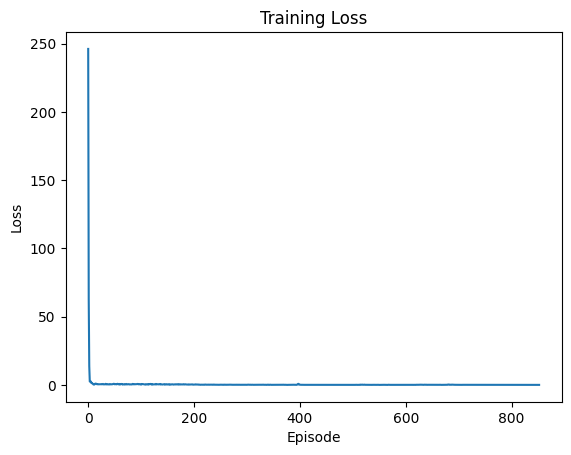

In [ ]:
import matplotlib.pyplot as plt

plt.plot(episode_losses)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [ ]:
episode_losses

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [48]:
def play_against_agent(env, qnet, params, random_key=jax.random.PRNGKey(0)):
    def get_agent_action(state):
        q_values = qnet.apply(params, state)
        valid_actions = jnp.arange(9)[env.valid_actions()]
        return valid_actions[jnp.argmax(q_values[valid_actions])]

    def get_human_action():
        while True:
            try:
                action = int(input("Enter your move (0-8): "))
                if action in env.valid_actions():
                    return action
                else:
                    print("Invalid move. Try again.")
            except ValueError:
                print("Invalid input. Enter a number between 0 and 8.")

    env.reset()
    env.print_board()

    env.current_player = int(input("Do you want to play first (-1) or second (1)? "))

    while not env.done:
        if env.current_player == -1:
            action = get_human_action()
        else:
            action = get_agent_action(env.board)
            print(f"Agent's move: {action}")

        env.step(action)
        env.print_board()

    if env.reward == 1:
        print("Agent wins!")
    elif env.reward == -1:
        print("You win!")
    else:
        print("It's a draw!")

# Play against the trained agent
play_against_agent(env, qnet, params)

---------
- | - | -
- | - | -
- | - | -
---------
Agent's move: 4
[0 0 0 0 1 0 0 0 0]
[0 0 0 0 1 0 0 0 0]
---------
- | - | -
- | X | -
- | - | -
---------
[-1  0  0  0  1  0  0  0  0]
[-1  0  0  0  1  0  0  0  0]
---------
O | - | -
- | X | -
- | - | -
---------
Agent's move: 2
[-1  0  1  0  1  0  0  0  0]
[-1  0  1  0  1  0  0  0  0]
---------
O | - | X
- | X | -
- | - | -
---------
[-1  0  1  0  1  0 -1  0  0]
[-1  0  1  0  1  0 -1  0  0]
---------
O | - | X
- | X | -
O | - | -
---------
Agent's move: 7
[-1  0  1  0  1  0 -1  1  0]
[-1  0  1  0  1  0 -1  1  0]
---------
O | - | X
- | X | -
O | X | -
---------
[-1 -1  1  0  1  0 -1  1  0]
[-1 -1  1  0  1  0 -1  1  0]
---------
O | O | X
- | X | -
O | X | -
---------
Agent's move: 8
[-1 -1  1  0  1  0 -1  1  1]
[-1 -1  1  0  1  0 -1  1  1]
---------
O | O | X
- | X | -
O | X | X
---------
[-1 -1  1 -1  1  0 -1  1  1]
[-1 -1  1 -1  1  0 -1  1  1]
---------
O | O | X
O | X | -
O | X | X
---------
You win!


In [ ]:
a = jnp.array([0.,1.,0.,0.,0.,0.,0.,0.,0.])
print(a)

[0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
jnp.argmax(a)

Array(1, dtype=int32)

In [ ]:
a[4,2]

Array(9., dtype=float32)

In [ ]:
env.step((0,1))

In [ ]:
env.board

Array([[0, 1, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int32)

In [ ]:
env.print_board()

[['-' 'X' '-']
 ['-' '-' '-']
 ['-' '-' '-']]


In [ ]:
jnp.array(env.valid_actions()).T

Array([[0, 0],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]], dtype=int32)

In [ ]:
b = jnp.array((1,-2,3))
c = jnp.array((-1, 2, 3))

In [ ]:
a_list = list(a)
print(a_list)

[Array([1, 2, 3], dtype=int32), Array([4, 5, 6], dtype=int32), Array([7, 8, 9], dtype=int32)]


In [ ]:
jnp.any(b==3)

Array(True, dtype=bool)

In [ ]:
if b.all() == 2 or c.all() == 3:
    print("a")

In [ ]:
jnp.empty(shape=(3,3), dtype=int)

Array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int32)

In [ ]:
a = jnp.array(((1,2,3), (4,5,6), (7,8,9)))
print(a)
print(jnp.sum(a, axis = 1))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[ 6 15 24]


In [ ]:
jnp.rot90(a)

Array([[3, 6, 9],
       [2, 5, 8],
       [1, 4, 7]], dtype=int32)

In [ ]:
jnp.diag(a)

Array([1, 5, 9], dtype=int32)